# Subreddit Community Submissions EDA: r/iosgaming vs r/androidgaming

## Problem Statement

##### r/androidgaming vs r/iosgaming
There is a constant divide between availability of ios games vs android gaming, however, there is a larger overlap of games that support both systems. Our game development company is, unfortunately, unable to develop for both platforms. As an independent company, we'd like to focus on community culture and release our game for that community first. However, we've found gamers are polarizing in hardware, software, and company support. We'd like to release to the community that appeals to our culture first, but plan for release to the other market. 


We will look into posts from both subreddits to find trends and inferences that separate the two crowds. Once identified we can begin looking into methods and verbiage that identifies our target market without alienating the other.


## Executive Summary:

Despite gamer trends of polarizing identification preferences and company support, we found users of both r/iosgaming and r/android were harder to tell apart from scratch. 

Our model trained and test scored with 99% accuracy opening up the resource of word and language trends between the two subreddits. With mroe time and research we can explore communication and community outreach practices that do not alienate either market as well as post-trends we can associate to game-types and releases.

With limited funding, our North American based game development company will look to release to the larger Android gaming market utilizing it's lower barrier of entry for game release and larger global popularity. As we found both subreddits to share both similar posting rules and have an overlapping game market, we are interested in utilizing further model findings within our Advertising team.

### Contents:

- [Library-Imports](#Library-Imports)
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Data-Visualization)
- [Model Findings](#Model-Findings)
- [External Research](#External-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Dictionary

**Model Testing Journals**
- [Logistic Regression Modeling](./code/LR_Modeling.ipynb)
- [K-Nearest Neighbors Modeling](./code/KNN_Modeling.ipynb)
- [Gaussian Naive Bayes Modeling](./code/NB_Modeling.ipynb)


***Dataframes:***
- `df` : our full scrape of 1000 post pulls, looped 100 times. Total 36,200 submissions.
- `traindf` : temp dataframe variable created for cleaning
- `subsdf` : data frame of posts after being cleaned, with target categories 50/50 split
 - target column created: `'is_iosgaming'
    - r/iosgaming = 1
    - r/androidgaming = 0
- `droid_df` : temp android gaming-only subreddits we sampled from our scrape to match quantity of iosgaming posts
- `ios_df` : df of all r/iosgaming posts
- `testdf` : new data pulled for testing our model on.    

***Features, variables, and lists:***
- `date_time` : string format of date for epoch conversion.
- `pattern` : string format of date pattern conversion
- `epoch_start` : January 1st, 2020, we converted this date to an epoch as our starting date for post scraping
- `epoch_end` : April 1st, 2020, we converted this date to an epoch for 4 month scrape. Pushshift api handled a webscrape of post size over date range.
    - ultimately this was not used
- `base_url` : string of url to pusshift api on reddit submissions
- `subreddit` : list of our subreddits as a string
- `epoc` : manual entry of epoch_start integers
- `punct`, `extra_stops`, `stops` : list and list comprehension to build stopwords from stopwords library 'english'
    - included additional: punctuation, terms and symbols that initial stoplist missed
- `ios_list`, `ios_raw`, `ios_clean`, `ios_freq` : masks for lists and tokens generated for frequency comparison
- `droid_list`, `droid_raw`, `droid_clean`, `droid_freq` : masks for lists and tokens generated for frequency comparison
- `X, y, and variants` : These are our regression feature and variable assignments. code blocks will contain descriptions of each.

***Modeling***
- `Pipeline`, `GridsearchCV`, `DenseTransformer` : hyper parameter classes for transforming our features
- `KNeighborsClassifier`, `LogisticRegression`, `GaussianNB` : regression models selected for research
- `cvec` : temporary instance of CountVectorizer
- `tvec` : temporary instance of TfidfVectorizer
- `pipe` : pipeline mask instance for transformers and predictors
- `pipe_params` : dict format of hyperparameters we test in each model
- `gs` : mask for gridsearch
- `best_@@@` : iteration of our saved best estimator parameters for each model
    
    
***Functions***
- `reddit_posts`
- `freq_table`
- `freq_compare`

***Datasets***
- `subredditposts_table.csv` : raw scrape of posts; (36200, 4) shape
- `subs.csv` : data frame of posts after being cleaned
 - target converted into binary column `'is_iosgaming'` where ios_gaming subreddit = 1, droid = 0



# Library Imports

In [224]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from nltk import word_tokenize, FreqDist
import nltk
from nltk.corpus import stopwords
import random
import seaborn as sns
from time import sleep
import string
import time

# Data Import and Cleaning

In [2]:
##Time conversions!!!
date_time = '01.01.2020 00:00:01' #beginning of year
pattern = '%d.%m.%Y %H:%M:%S'
epoch_start = int(time.mktime(time.strptime(date_time, pattern)))
print(epoch_start)

date_time = '01.04.2020 00:00:01' #current
pattern = '%d.%m.%Y %H:%M:%S'
epoch_end = int(time.mktime(time.strptime(date_time, pattern)))
print(epoch_end)

#https://stackoverflow.com/a/7241238

1577865601
1585724401


In [158]:
# take base url, subreddit(s), epoch time for before, iterate over 1000
def reddit_posts(base_url, subreddit, epoch, n_iter):
    df_list = []
    for _ in range(n_iter):
        res = requests.get(base_url, 
                           params = {
                               'subreddit' : subreddit,
                               'size' : 1000,
                               'lang' : True,
                               'before' : epoch,
                               'user_removed' : False,
                               'mod_removed' : False,
                               'selftext' : True
                           })  #takes params as a dict
        df = pd.DataFrame(res.json()['data'])
        df = df.loc[:, ['title', 'selftext', 'subreddit', 'created_utc']] # pulls desired text
        df_list.append(df) #appends to list
        time.sleep(1)
        current_time = df.created_utc.min()
    return pd.concat(df_list, axis = 0)
    

# masks it
# mask again and convert old mask to json
# list comp your data
# build the data frame

In [4]:
# run function and scrape posts
base_url = 'https://api.pushshift.io/reddit/submission/search'
subreddit = ['iosgaming', 'androidgaming']
epoc = 1577865601
df = reddit_posts(base_url, subreddit, epoc, 100)

In [5]:
print(df.shape)
print(df.columns)

(36200, 4)
Index(['title', 'selftext', 'subreddit', 'created_utc'], dtype='object')


In [7]:
# our dataframe is complete
df.to_csv('./datasets/subredditposts_table.csv', index = False)

In [8]:
#brief cleaning to prepare our data for modeling
## checklist: create target column, even category balance, 

In [9]:
# target column

In [10]:
traindf = df

In [11]:
traindf['is_iosgaming'] = traindf['subreddit'].str.lower().map({
    'iosgaming' : 1,
    'androidgaming' : 0
})

In [12]:
traindf.is_iosgaming.value_counts()

0    25500
1    10700
Name: is_iosgaming, dtype: int64

In [13]:
#randomly samples android gaming posts to match number of iosgaming posts 
droid_df = traindf[traindf['is_iosgaming']==0].sample(n = traindf.is_iosgaming.value_counts()[1], replace = False, random_state = 42)

In [14]:
ios_df = traindf[traindf['is_iosgaming']==1]

In [15]:
print(f'IOS Shape: {ios_df.shape}')
print(f'Android Shape: {droid_df.shape}')

IOS Shape: (10700, 5)
Android Shape: (10700, 5)


In [16]:
#now we combine our dataframes
subsdf = pd.concat([ios_df, droid_df], axis = 0) #concat and set axis along rows

In [17]:
subsdf.shape # looks good!

(21400, 5)

In [18]:
# save our prepped modeling data
subsdf.to_csv('./datasets/subsdf.csv')

# Exploratory Data Analysis

In [ ]:
# tokenize corpus
# distill stops
# identify word trends

In [25]:
#read in our data frame
subsdf = pd.read_csv('./datasets/subs.csv', )

#drop unnecessary column 
subsdf.drop(columns='Unnamed: 0', inplace = True)

#combine our text columns
subsdf['corpus'] = subsdf['title'] + subsdf['selftext']
ios_df = subsdf[subsdf['is_iosgaming']==1]
droid_df = subsdf[subsdf['is_iosgaming']==0]

# confirm even target spread
subsdf['is_iosgaming'].value_counts()

1    10700
0    10700
Name: is_iosgaming, dtype: int64

In [124]:
# list comp to pull punctuation from string library
punct = [i for i in string.punctuation]

# use basic stop words 'english' dict
stops = stopwords.words('english')

# adds punctuation
stops.extend(punct)

#remove additional high occurring symbols and words
extra_stops = ['--', '""', "''", "n't", "'", "``", 'https', "'s", 'http', 'amp', 'nbsp' ]
stops.extend(extra_stops)

In [61]:
# we will use ios_df and droid_df to compare word frequencies to 
## assist in hyper parameter and model selection

In [120]:
#function pulled from class codealong DSI-11 cohort
def freq_compare(text1, text2, text1_name="", text2_name="", limit=None, hapaxes=False):

    freqs1 = nltk.FreqDist(text1).most_common(limit)
    freqs2 = nltk.FreqDist(text2).most_common(limit)
    prob1 = [round(x[1]/len(freqs1),2) for x in freqs1]
    prob2 = [round(x[1]/len(freqs2),2) for x in freqs2]

    freq1 = zip(freqs1, prob1)
    freq2 = zip(freqs2, prob2)

    freqs = [freq1, freq2]
    
    comp_freqs = []
    for f in freqs:
        for s,p in f:
            comp_freqs.append([s[0],s[1],p])
    
    cfreq1 = comp_freqs[:26]
    cfreq2 = comp_freqs[26:]

    print(f'  {text1_name.upper()} \t\t    {text2_name.upper()}')

    for i in zip(cfreq1, cfreq2):
        print(i[0], " "*(25-len(str(i[0]))),i[1])

In [83]:
#function pulled from class codealong DSI-11 cohort
def freq_table(text, count=None):

    freqs = FreqDist(text).most_common()
    prob = [round(x[1]/len(text),4) for x in freqs]

    freq = zip(freqs,prob)

    comp_freqs = []
    for s,p in freq:
        comp_freqs.append([s[0],s[1],p])

    comp_freqs.sort(key=lambda tup: tup[1], reverse=True) #Sort the list so it's in order, big to small

    if count == None:
        most = comp_freqs[:26]    
        hapax = comp_freqs[:-25:-1]
    else:
        most = comp_freqs[:count + 1]
        hapax = comp_freqs[:-count:-1]

    print('Most Common \t\t\tLeast Common')

    for i in zip(most, hapax):
        print(i[0], " "*(30-len(str(i[0]))),i[1])
        
# SEA-FLEX-11 CODE_ALONG @Charles-Rice


#### r/iosgaming - Word Frequency
- We take a look at most common and least common words 
- Notes: r/iosgaming had a larger amount of symbols and format terms that made the frequency list. `extra_stops` was created to alleviate most of the problem terms.

In [125]:
# combine your text
ios_list = ios_df['corpus'].to_list()

# join them
ios_raw = ' '.join(ios_list)


# tokenize
ios_list = word_tokenize(ios_raw.lower())

# remove stops and punctuation
ios_clean = [i for i in ios_list if i not in stops]
freq_table(ios_clean)

Most Common 			Least Common
['game', 45700, 0.0246]         ['www.twitter.com/wtrebella', 100, 0.0001]
['games', 18500, 0.01]          ['twitter', 100, 0.0001]
['**episode', 12800, 0.0069]    ['www.whitakerblackall.com', 100, 0.0001]
['like', 12600, 0.0068]         ['creations', 100, 0.0001]
['’', 11500, 0.0062]            ['tweet', 100, 0.0001]
['true', 11000, 0.0059]         ['molecule-forming', 100, 0.0001]
['one', 9800, 0.0053]           ['revel', 100, 0.0001]
['time', 9300, 0.005]           ['creation', 100, 0.0001]
['get', 9200, 0.005]            ['similarly', 100, 0.0001]
['play', 8800, 0.0047]          ['regular', 100, 0.0001]
['ios', 8700, 0.0047]           ['bored', 100, 0.0001]
['good', 7100, 0.0038]          ['matching', 100, 0.0001]
['39', 7100, 0.0038]            ['rivers', 100, 0.0001]
['really', 7000, 0.0038]        ['roads', 100, 0.0001]
['would', 6700, 0.0036]         ['fields', 100, 0.0001]
['new', 6700, 0.0036]           ['procedurally', 100, 0.0001]
['also', 6400, 

#### r/androidgaming - Word Frequency
- We take a look at most common and least common words 

In [126]:
# combine your text
droid_list = droid_df['corpus'].to_list()

# join them
droid_raw = ' '.join(droid_list)


# tokenize
droid_list = word_tokenize(droid_raw.lower())

#remove stops and punctuation
droid_clean = [i for i in droid_list if i not in stops]

#table
freq_table(droid_clean)

Most Common 			Least Common
['game', 70774, 0.0209]         ['mythology', 30, 0.0]
['games', 30168, 0.0089]        ['progressions', 30, 0.0]
['get', 25370, 0.0075]          ['stumbled', 30, 0.0]
['one', 21809, 0.0064]          ['iapsi', 30, 0.0]
['//play.google.com/store/apps/details', 21281, 0.0063]  ['paywall', 30, 0.0]
['play', 21237, 0.0063]         ['btw', 30, 0.0]
['like', 19966, 0.0059]         ['++', 30, 0.0]
['time', 16155, 0.0048]         ['id=com.hackedapp', 30, 0.0]
['mobile', 14440, 0.0043]       ['hacked', 30, 0.0]
['free', 14320, 0.0042]         ['hackedhi', 30, 0.0]
['true', 14080, 0.0042]         ['policy', 30, 0.0]
['really', 13137, 0.0039]       ['rep', 30, 0.0]
['make', 12963, 0.0038]         ['booth', 30, 0.0]
['also', 12094, 0.0036]         ['reflashed', 30, 0.0]
['want', 11976, 0.0035]         ['id=putasock.faroffdaydream', 30, 0.0]
['’', 11934, 0.0035]            ['talent', 30, 0.0]
['even', 11881, 0.0035]         ['irks', 30, 0.0]
['good', 11821, 0.0035]       

#### r/iosgaming + r/androidgaming
- external research revealed that ios users tend to have higher spending habits and focus on brand loyalty, so we're not really surprised to see `ios` and `good` appearing in the top used words. 
 - considering the subreddit categorizes as iosgaming, it's worth noting that ios is one of the most frequently occurring words.
 - `r/androidgaming` on the other hand, is looking more generalized and shares similarly repeated words frequent to gaming
  - `free` is a more common appearing word and unique to top 20 words in  `r/iosgaming`
  - `pay` however, is a more common appeariong word and unique to top 20 words in `r/androidgaming`

- [External Research](#External-Research) for source list

- *Special Note*: Our 30 least common words captured for frequency we found consisted of several mobile game titles. Each game, however, is available for both systems.

In [130]:
# combined
freq_compare(ios_clean, droid_clean, 'r/iosgaming', 'r/androidgaming')

  R/IOSGAMING 		    R/ANDROIDGAMING
['game', 45700, 9.2]       ['want', 4700, 0.95]
['games', 18500, 3.73]     ['played', 4700, 0.95]
['**episode', 12800, 2.58]  ['players', 4600, 0.93]
['like', 12600, 2.54]      ['lot', 4500, 0.91]
['’', 11500, 2.32]         ['review**', 4500, 0.91]
['true', 11000, 2.22]      ['make', 4400, 0.89]
['one', 9800, 1.97]        ['playing', 4300, 0.87]
['time', 9300, 1.87]       ['**', 4200, 0.85]
['get', 9200, 1.85]        ['app', 4200, 0.85]
['play', 8800, 1.77]       ['even', 4100, 0.83]
['ios', 8700, 1.75]        ['gameplay', 4100, 0.83]
['good', 7100, 1.43]       ['way', 4000, 0.81]
['39', 7100, 1.43]         ['well', 4000, 0.81]
['really', 7000, 1.41]     ['level', 3800, 0.77]
['would', 6700, 1.35]      ['week', 3800, 0.77]
['new', 6700, 1.35]        ["'ll", 3700, 0.75]
['also', 6400, 1.29]       ['looking', 3600, 0.73]
['free', 5700, 1.15]       ['experience', 3600, 0.73]
['mobile', 5600, 1.13]     ['great', 3500, 0.7]
['based', 5600, 1.13]      ['fu

In [46]:
# Let's explore word counts via CountVectorizer as a whole

In [65]:
# Establish our word features
X = subsdf['corpus']

#instanstiate CountVectorizer, lower case our words
cvec = CountVectorizer(lowercase=True, stop_words = stops)

#fit the CountVectorizer
cvec.fit(X)

#transform
X_cv = cvec.transform(X)



In [66]:
# now let's look at our compiled word columns
words = pd.DataFrame(X_cv.todense(), columns=cvec.get_feature_names())

In [67]:
words.sum().sort_values(ascending=False).head(30)

game        120321
com          93342
https        72187
play         55831
games        53674
amp          47570
like         35593
google       35552
get          34732
one          32480
store        31096
apps         29600
www          29597
free         28021
true         27652
time         26837
reddit       24673
details      22299
id           22014
app          21033
first        20929
nbsp         20708
comments     20668
mobile       20349
really       20186
good         19253
new          18876
also         18494
episode      17780
make         17463
dtype: int64

In [68]:
words.sum().sort_values(ascending=True).head(30)

8c3vzx              30
heroesparadox       30
r2roadstudio        30
emptive             30
belong              30
inverse             30
qualify             30
distraction         30
bite                30
mythology           30
roguesnail          30
cleanly             30
rpgmaker            30
rr                  30
calls               30
pixelspacehorror    30
ruby                30
btw                 30
arenaquestrpg       30
putasock            30
om                  30
gfactoriser         30
unpopular           30
pushes              30
natemonster         30
sarpgfull           30
dungeonwarfare      30
swap                30
swapheroes2         30
tfor                30
dtype: int64

In [143]:
# pulled from flex-review on EDA @Charles-Rice
def remove_stop_words(text):
    return [word.lower() for word in text if word.lower() not in stops]

In [144]:
#establish df for tokenizing and establishing bigrams
tempdf = subsdf.drop(columns=['selftext','title'])
tempdf['tokens'] = tempdf['corpus'].apply(nltk.word_tokenize)
tempdf['tokens'] = tempdf['tokens'].apply(remove_stop_words)

# tokens!
ios_tokens = tempdf[tempdf['is_iosgaming'] == 1]
droid_tokens = tempdf[tempdf['is_iosgaming'] == 0]

#flatten
ios_toke = [item for sublist in list(ios_tokens['tokens']) for item in sublist]
droid_toke = [item for sublist in list(droid_tokens['tokens']) for item in sublist]

#bi-gram associations
ios_bgs = nltk.bigrams(ios_toke)
droid_bgs = nltk.bigrams(droid_toke)


#load into FreqDist
ios_fdist = nltk.FreqDist(ios_bgs)
droid_fdist = nltk.FreqDist(droid_bgs)

In [145]:
ios_fdist.most_common(25)

[(('**tl', 'dr'), 2800),
 (('game', 'size'), 2100),
 (('free', '**genre**'), 2100),
 (('**required', 'attention**'), 2100),
 (('dr', 'review**'), 2100),
 (('**first', 'impressions'), 2100),
 (('impressions', 'review**'), 2100),
 (('fantasy|turn', 'based'), 2000),
 (('**app', 'store**'), 1900),
 (("'ve", 'played'), 1800),
 (('tl', 'dr'), 1700),
 (('mt=8', 'ign-mpt=uo'), 1700),
 (('ign-mpt=uo', '3d4'), 1700),
 (('3d4', '\\-'), 1700),
 (('mb', 'free'), 1600),
 (('turn', 'based'), 1500),
 (('call', 'duty'), 1500),
 (('app', 'store'), 1500),
 (('ios', 'games'), 1400),
 (('\\-', 'free'), 1400),
 (('battle', 'royale'), 1300),
 (('would', 'like'), 1300),
 (('chaos', 'rings'), 1300),
 (('games', 'like'), 1200),
 (('person', 'shooter'), 1200)]

In [146]:
droid_fdist.most_common(25)

[(('last', 'day'), 3402),
 (('day', 'earth'), 3402),
 (('mobile', 'gaming'), 3235),
 (('**tl', 'dr'), 3057),
 (('true', 'skate'), 2961),
 (('google', 'play'), 2848),
 (('dr', 'review**'), 2720),
 (('**google', 'play**'), 2720),
 (('play**', '//play.google.com/store/apps/details'), 2720),
 (('impressions', 'review**'), 2720),
 (('make', 'sure'), 2602),
 (('mobile', 'games'), 2594),
 (('free', '**genre**'), 2480),
 (('tl', 'dr'), 2456),
 (('game', 'size'), 2305),
 (('play', 'store'), 2173),
 (('free', 'play'), 2108),
 (('mb', 'free'), 1942),
 (('**first', 'impressions'), 1850),
 (('mobile', 'game'), 1604),
 (('even', 'though'), 1601),
 (('link', '//play.google.com/store/apps/details'), 1480),
 (('really', 'good'), 1417),
 (("'ve", 'played'), 1301),
 (('tips', 'tricks'), 1290)]

# Data Visualization

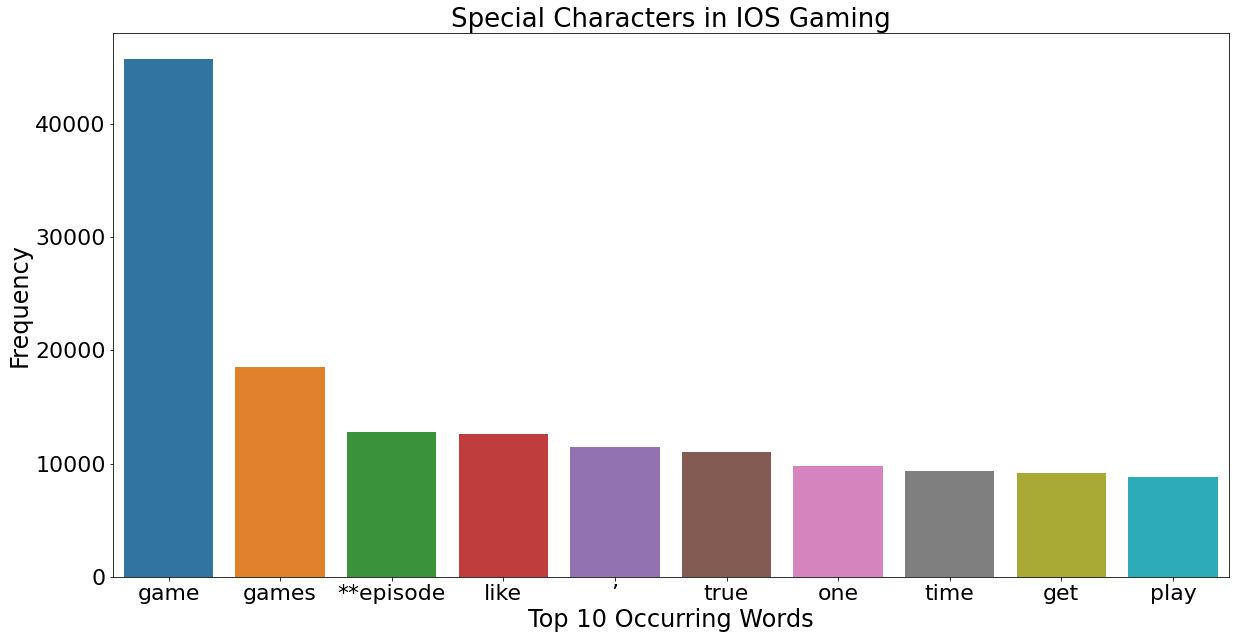

In [127]:
# IOS gaming word frequency
ios_freq = FreqDist(ios_clean).most_common(10)

x = [x[0] for x in ios_freq]

y = [x[1] for x in ios_freq]


plt.figure(figsize=(20,10))
plt.title("Special Characters in IOS Gaming", fontsize = 26)
plt.xlabel("Top 10 Occurring Words", fontsize = 24)
plt.ylabel("Frequency", fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
sns.barplot(x = x, y= y);

In [128]:
droid_labels = ['game', 'games', 'get', 'one', 'google.com', 'play', 'like', 'time', 'mobile', 'free']

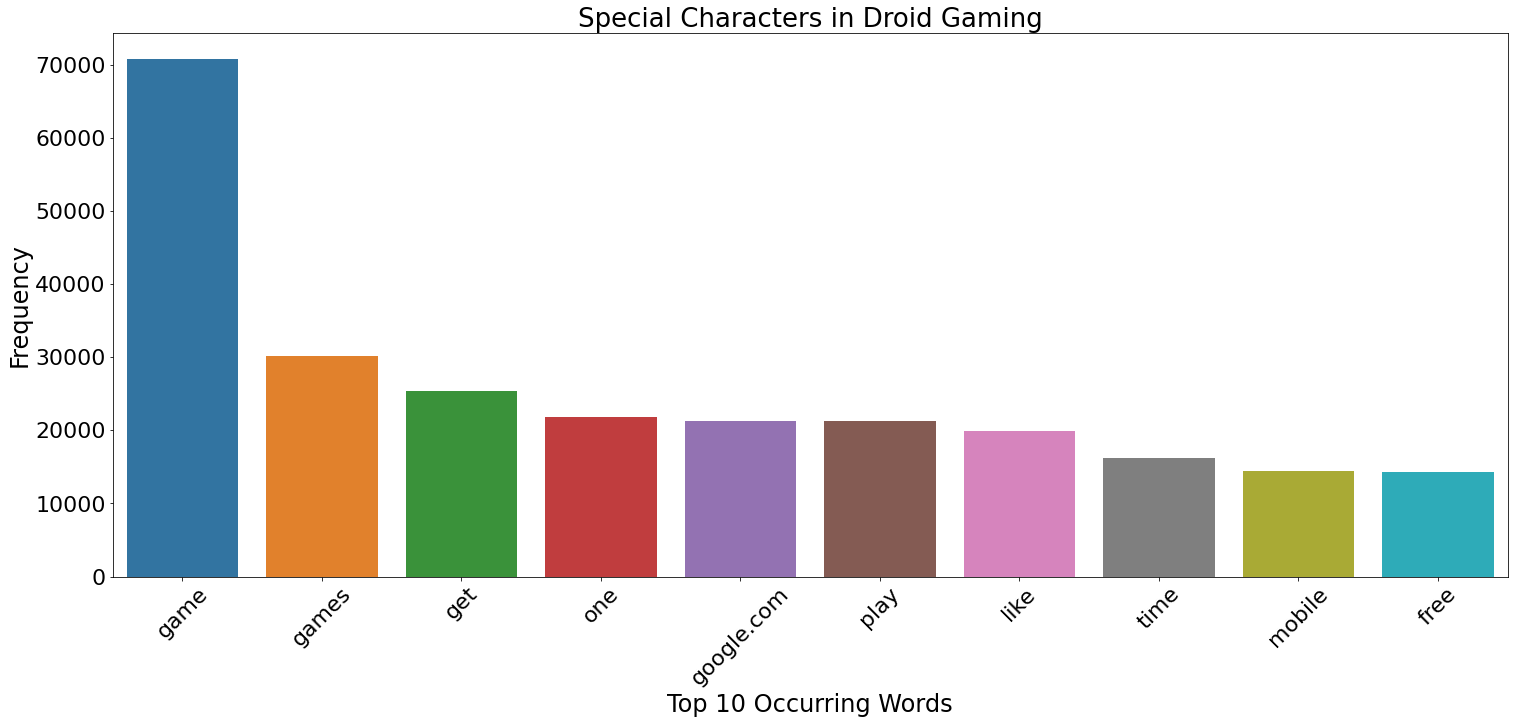

In [129]:
droid_freq = FreqDist(droid_clean).most_common(10)

x = [x[0] for x in droid_freq]

y = [x[1] for x in droid_freq]

fig, ax = plt.subplots(figsize=(25, 10))
bar = sns.barplot(x = x, y = y)
ax.set_xticklabels(droid_labels)
plt.title("Special Characters in Droid Gaming", fontsize = 26)
plt.xlabel("Top 10 Occurring Words", fontsize = 24)
plt.ylabel("Frequency", fontsize = 24)
plt.xticks(fontsize = 22, rotation = 45)
plt.yticks(fontsize = 22);

In [135]:
# pulled from flex-review on EDA @Charles-Rice
def remove_stop_words(text):
    return [word.lower() for word in text if word.lower() not in stops]

In [140]:
#establish df for tokenizing and establishing bigrams
tempdf = subsdf.drop(columns=['selftext','title'])
tempdf['tokens'] = tempdf['corpus'].apply(nltk.word_tokenize)
tempdf['tokens'] = tempdf['tokens'].apply(remove_stop_words)

# tokens!
ios_tokens = tempdf[tempdf['is_iosgaming'] == 1]
droid_tokens = tempdf[tempdf['is_iosgaming'] == 0]

#flatten
ios_toke = [item for sublist in list(ios_tokens['tokens']) for item in sublist]
droid_toke = [item for sublist in list(droid_tokens['tokens']) for item in sublist]

#bi-gram associations
ios_bgs = nltk.bigrams(ios_toke)
droid_bgs = nltk.bigrams(droid_toke)


#load into FreqDist
ios_fdist = nltk.FreqDist(ios_bgs)
droid_fdist = nltk.FreqDist(droid_bgs)

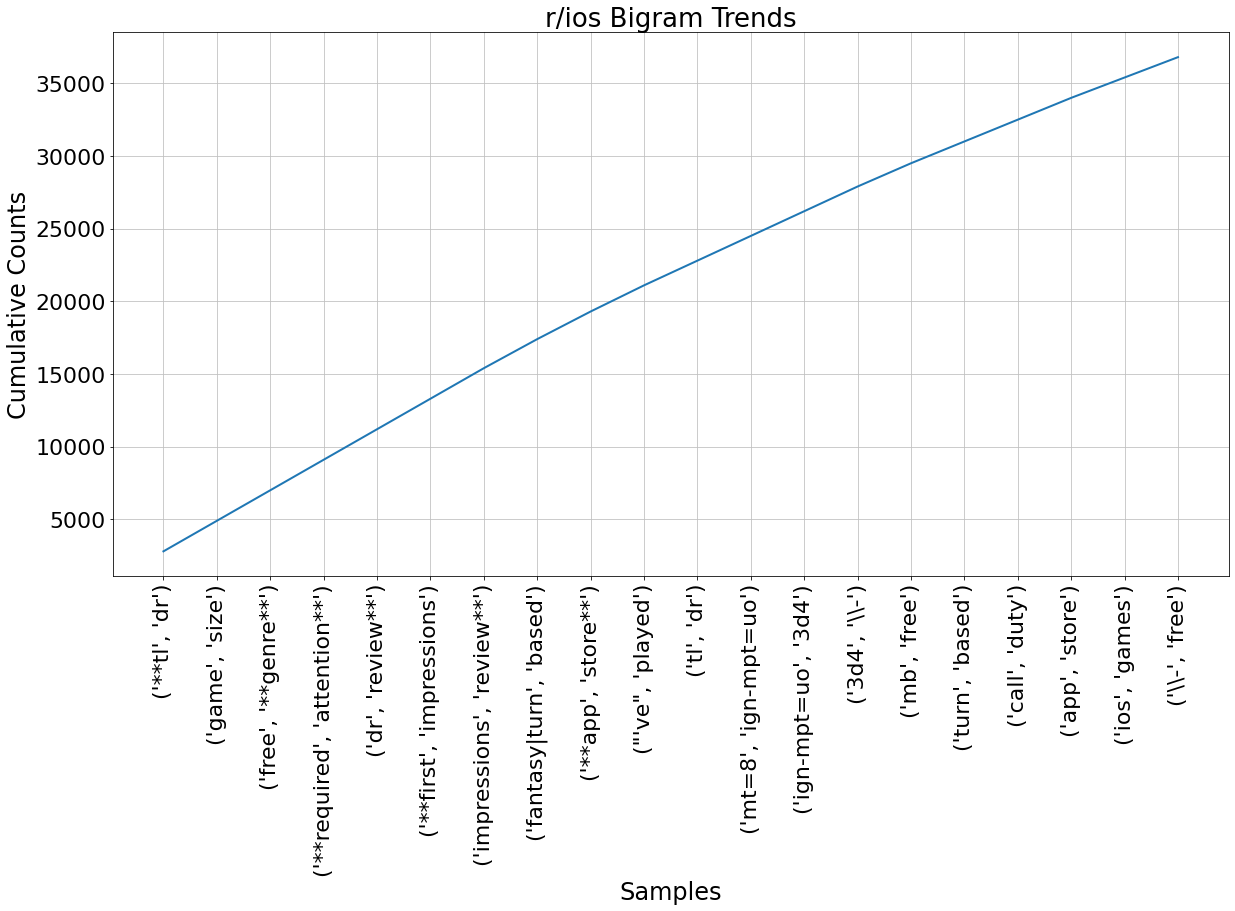

In [149]:
plt.figure(figsize=(20,10))
plt.title("r/iosgaming Bigram Trends", fontsize = 26)
plt.xlabel("Top 20 Occurring Words", fontsize = 24)
plt.ylabel("Cumulative Frequency", fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ios_fdist.plot(20, cumulative=True);

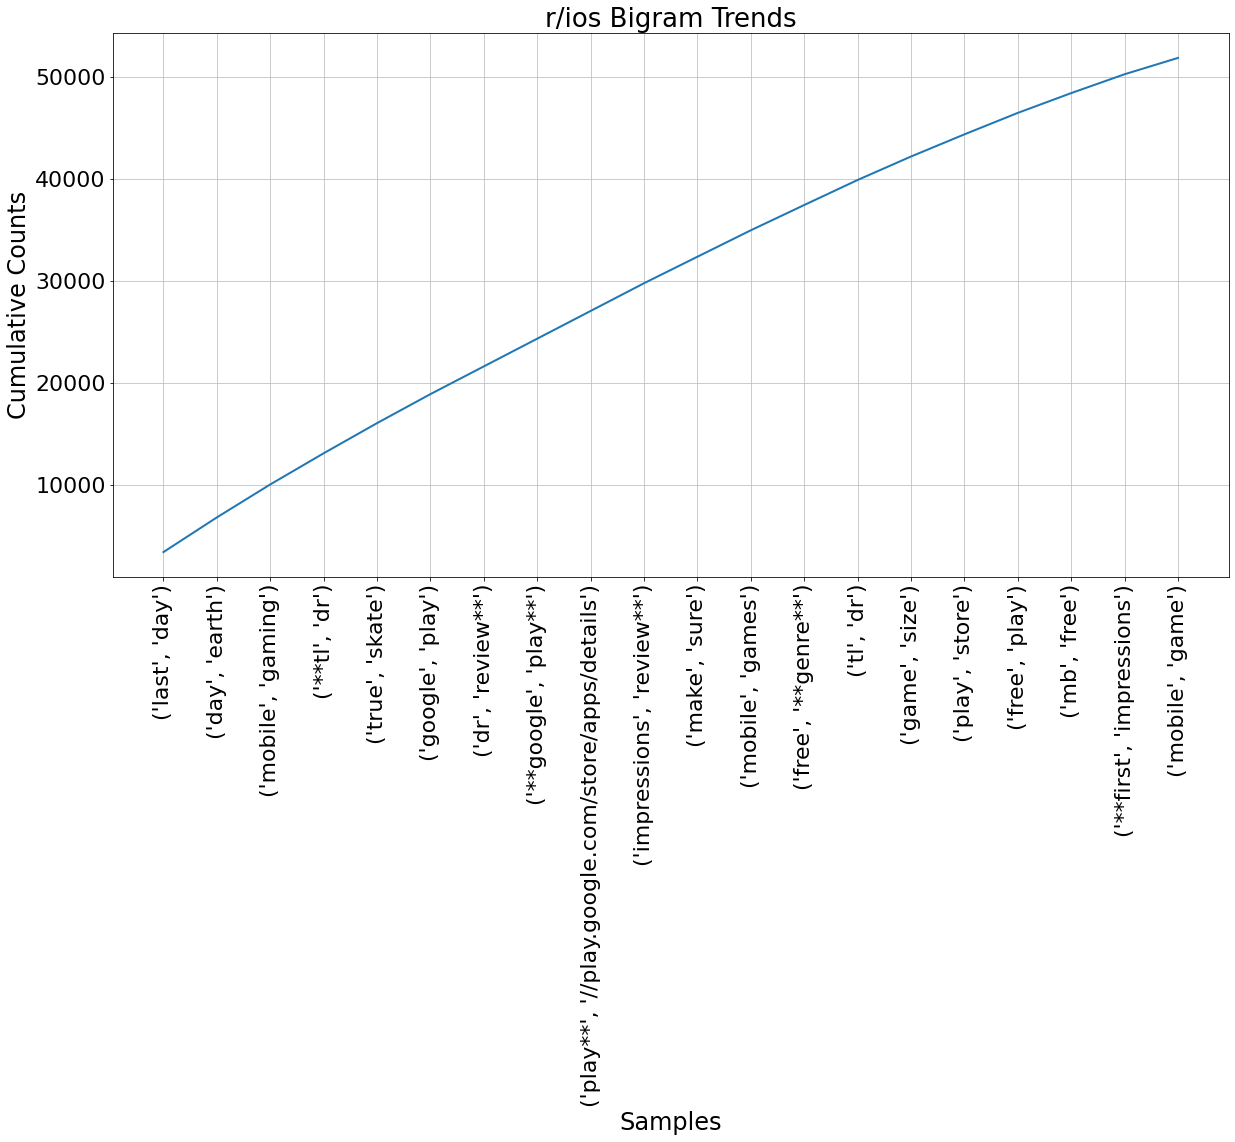

In [150]:
plt.figure(figsize=(20,10))
plt.title("r/androidgaming Bigram Trends", fontsize = 26)
plt.xlabel("Top 20 Occurring Words", fontsize = 24)
plt.ylabel("Cumulative Frequency", fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
droid_fdist.plot(20, cumulative=True);

# Modeling Findings

#### Logistic
- `Pipe`: `LogisticRegression()`, `CountVectorizer()`
- `Best Score:` 0.9936448598130841
- `Test Score:` 0.9958878504672897
<br><br>
- `Pipe`: `LogisticRegression()`, `TfidfVectorizer()`
- `Best Score:` 0.9954517133956386
- `Test Score:` 0.9962616822429906

#### K-Nearest Neighbors
- `Pipe`: `KNNeighborsClassifier()`, `CountVectorizer()`, `DenseTransformer()`
- `Best Score:` 0.9949532710280373
- `Test Score:` 0.9945794392523365
<br><br>
- `Pipe`: `KNNeighborsClassifier()`, `TfidfVectorizer()`, `DenseTransformer()`
- `Best Score:` 0.9948286604361372
- `Test Score:` 0.9962616822429906

#### Naive Bayes Gaussian
- `Pipe`: `GaussianNB()`, `CountVectorizer()`, `DenseTransformer()`
- `Best Score:` 0.8175700934579438
- `Test Score:` 0.8250467289719626
<br><br>
- `Pipe`: `GaussianNB()`, `TfidfVectorizer()`, `DenseTransformer()`
- `Best Score:` 0.9682242990654206
- `Test Score:` 0.9706542056074766

#### Testing our best model on fresh data

In [174]:
##Time conversions!!!
date_time = '01.01.2019 00:00:01' # start half year back
pattern = '%d.%m.%Y %H:%M:%S'
epoch_start = int(time.mktime(time.strptime(date_time, pattern)))
print(epoch_start)

1546329601


In [184]:
epoch = 1546329601

In [197]:
df_list = []
res = requests.get(base_url, 
                   params = {
                       'subreddit' : ['iosgaming', 'androidgaming'],
                       'size' : 1000,
                       'lang' : True,
                       'before' : 1559372401,
                       'user_removed' : False,
                       'mod_removed' : False,
                       'selftext' : True
                   })  #takes params as a dict

In [198]:
res.status_code

200

In [199]:
df = pd.DataFrame(res.json()['data'])

In [200]:
df = df.loc[:, ['title', 'selftext', 'subreddit', 'created_utc']] 

In [201]:
df_list.append(df)

In [202]:
testdf = pd.concat(df_list, axis = 0)

In [203]:
testdf['is_iosgaming'] = testdf['subreddit'].str.lower().map({
    'iosgaming' : 1,
    'androidgaming' : 0
})

In [194]:
testdf['is_iosgaming'].value_counts(normalize=True)

0    0.727273
1    0.272727
Name: is_iosgaming, dtype: float64

In [204]:
testdf['corpus'] = testdf['selftext'] + testdf['title']

In [206]:
# save our prepped modeling data
testdf.to_csv('./datasets/testdf.csv')

In [208]:
# Logistical Regression Best-Parameters
tvec = TfidfVectorizer(analyzer='word', 
                       binary=False,
                       decode_error='strict',
                       encoding='utf-8', 
                       input='content',
                       lowercase=True, 
                       max_df=1.0, 
                       max_features=1000,
                       min_df=1, 
                       ngram_range=(1, 1), 
                       norm='l2',
                       preprocessor=None, 
                       smooth_idf=True,
                       stop_words=None, 
                       strip_accents=None,
                       sublinear_tf=False,
                       token_pattern='(?u)\\b\\w\\w+\\b',
                       tokenizer=None, use_idf=True,
                       vocabulary=None)

lr = LogisticRegression(C=1.0, 
                        class_weight=None, 
                        dual=False,
                        fit_intercept=True, 
                        intercept_scaling=1,
                        l1_ratio=None, 
                        max_iter=10000,
                        multi_class='auto', 
                        n_jobs=None,
                        penalty='none', 
                        random_state=None,
                        solver='saga', 
                        tol=0.0001, 
                        verbose=0,
                        warm_start=False)

In [221]:
# re-establish previous model
X = subsdf['corpus']
y = subsdf['is_iosgaming']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 14)
X_train_cv = cvec.fit_transform(X_train)
X_test_cv = cvec.transform(X_test)
lr.fit(X_train_cv, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [222]:
# final dataframe with fresh X and y
X_final = cvec.transform(testdf['corpus'])
y_final = testdf['is_iosgaming']

In [223]:
#capture some stats on model
print(f'Model Training Score: {lr.score(X_train_cv, y_train)}')
print(f'Model Test Score: {lr.score(X_test_cv, y_test)}')
print('And finally.... our model on fresh data')
print(f'Final score: {lr.score(X_final, y_final)}')

Model Training Score: 0.9954517133956386
Model Test Score: 0.9962616822429906
And finally.... our model on fresh data
Final score: 0.9935064935064936


# External Research Sources

- [IOS Gaming Subreddit](#https://www.reddit.com/r/iosgaming/)
- [Android Gaming Subreddit](#https://www.reddit.com/r/androidgaming/)
- [Android vs iOS: Which Platform to Build Your App for First?](#https://themanifest.com/mobile-apps/android-vs-ios-which-platform-build-your-app-first)
- [iOS App Users are Spending More...](#https://www.businessinsider.com/ios-app-users-are-spending-more-2017-5)
- [Android vs iOS](#https://www.itpro.co.uk/mobile/30409/android-vs-ios-which-mobile-os-is-right-for-you)

# Conclusions and Recommendations

We found both subreddits shared similar game interest, verbiage, and common posting habits. Our model scored over 99% on both our training and test sets. We then applied the model to new posts pulled from half a year earlier, the model scored over a 99% accuracy on the new data.

Using these parameters we can further explore common natural language trends.

Android gaming(Google PlayStore included) entry requirements and game upkeep are much less demanding than Apple. Apple is nefarious for its strict update reviews, game release filters, and family-appropriate approach to game-content (mostly).

Currently, our model will allow us to dive deeper into the language culture of each market. For now, app management, release requirements, and Apple's high-priced products that support iOS is what attracts and detracts users. Android gaming, with its wide-range of hardware support, larger quantity of game releases (good and bad), and lax development release process opens us to: more players, easier development response time.

With more time and research, we will explore our model to align our advertising and community outreach with the brand and culture we are trying to establish with our first release.